In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import quantum_info
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.classical import expr
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt
import numpy as np

### Iterative Quantum Phase Estimation using Dynamic Circuits

In [ ]:
def CU(num_qubits, exponent, name='U'):
    circuit = QuantumCircuit(num_qubits, name=name)
    theta = np.deg2rad(35.36)*exponent
    circuit.p(theta, 0)

    gate = circuit.to_gate()
    c_gate = gate.control()
    return c_gate

cu = CU(3, 0)

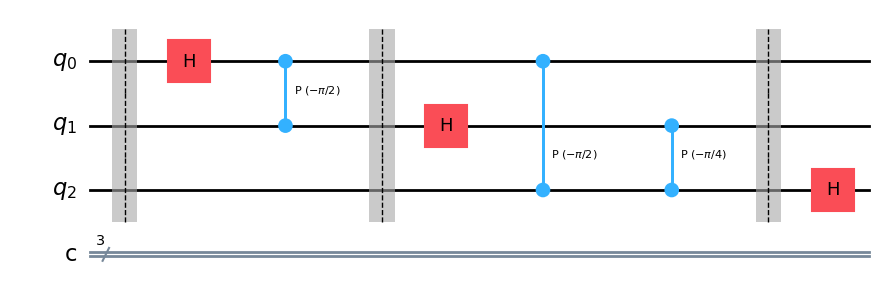

In [ ]:
c = 5
n = 1

qc = QuantumRegister(1, name='q')
qn = QuantumRegister(n, name='n')
cls = ClassicalRegister(c, name='c')

circuit = QuantumCircuit(qc, qn, cls)

for q in range(c):
    circuit.initialize(0, 0)
    circuit.initialize(1, 1)
    
    circuit.h(0)

    exp = 2**(c-q-1)
    print('exponent: ', exp)
    # with circuit.for_loop(range(exp)):
    cu = CU(n, exp)
    circuit.append(cu, [0,1])

    for q_ in range(q):
        with circuit.if_test(expr.lift(cls[-q_])):
            theta = 2*np.pi/(2**(q_+2))
            circuit.p(-theta, 0)

    circuit.h(0)

    circuit.measure(0, cls[q])
    circuit.barrier()

circuit.draw('mpl')

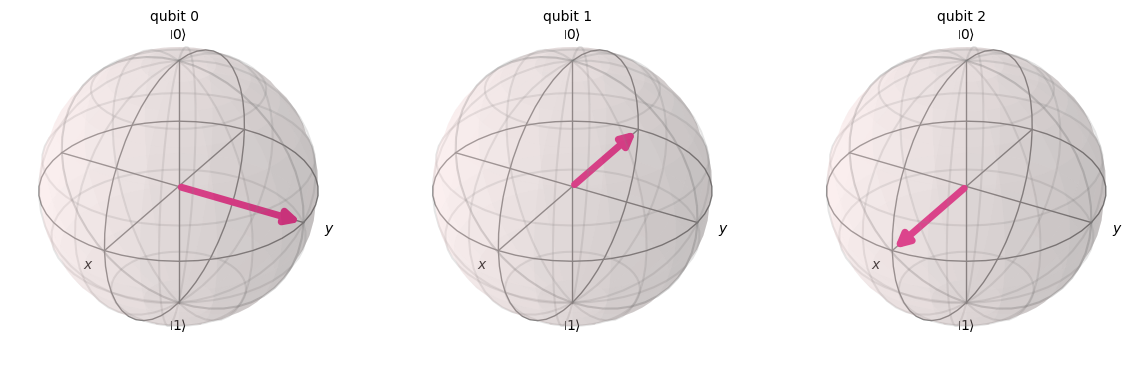

In [ ]:
from qiskit.circuit.library import QFT
iqft = QFT(c, do_swaps=False, inverse=True)

ket0 = quantum_info.Statevector([1, 0])
ket1 = quantum_info.Statevector([0, 1])

state1 = quantum_info.Statevector(ket0^ket1^ket1)

out_state1 = state1.evolve(iqft)
out_state1.draw('bloch')

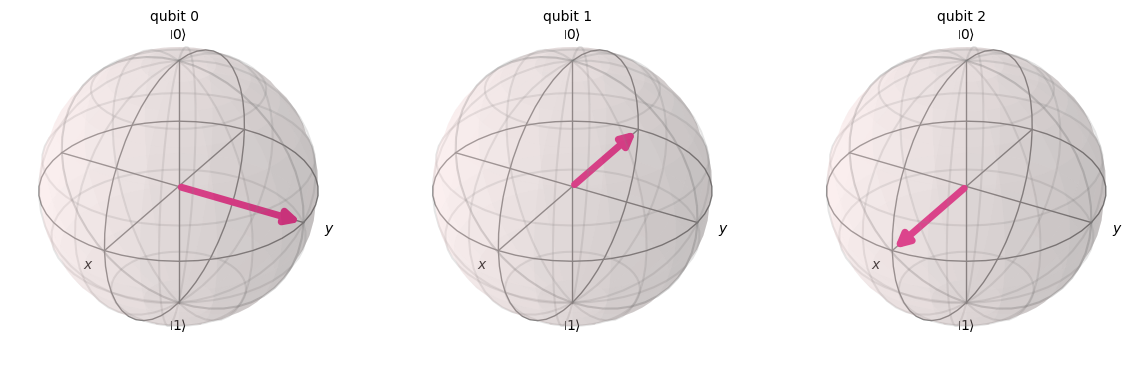

In [ ]:
state2 = quantum_info.Statevector(ket0^ket1^ket1)
out_state2 = state2.evolve(circuit)
out_state2.draw('bloch')

In [ ]:
backend = AerSimulator()
circuit_tp = transpile(circuit, backend=backend)
sampler = Sampler(backend)

result = sampler.run([circuit_tp], shots=1000).result()

stats = result[0].data.c.get_counts()
print('stats: ', stats)
phase_bit = max(stats, key = lambda k: stats[k])

print('\n\n-------------------------OUTPUT------------------------')
print(f'phase bit: [ {phase_bit} ]')

phase_int = int(phase_bit, 2)/(2**c)
print(f'phase decimal: {phase_int:.03f}')
theta = phase_int*2*np.pi
print(f'phase in degrees: {np.rad2deg(theta):.03f}')
print('-------------------------------------------------------')

print('\n\n-------------------------REVERSED-------------------------')
phase_bit = phase_bit[::-1]
print(f'phase bit reversed: [ {phase_bit} ]')

phase_int = int(phase_bit, 2)/(2**c)
print(f'phase decimal: {phase_int:.03f}')
theta = phase_int*2*np.pi
print(f'phase in degrees: {np.rad2deg(theta):.03f}')
print('-------------------------REVERSED-------------------------')

stats:  {'00110': 10, '01110': 6, '00011': 573, '00100': 21, '10011': 178, '00101': 3, '00111': 110, '00001': 2, '01100': 14, '01011': 9, '10111': 56, '01000': 1, '11011': 6, '10001': 2, '10100': 1, '00010': 2, '00000': 1, '11111': 1, '01111': 3, '01001': 1}


-------------------------OUTPUT------------------------
phase bit: [ 00011 ]
phase decimal: 0.094
phase in degrees: 33.750
-------------------------------------------------------


-------------------------REVERSED-------------------------
phase bit reversed: [ 11000 ]
phase decimal: 0.750
phase in degrees: 270.000
-------------------------REVERSED-------------------------


### Teleportation Circuit using Dynamic Circuits

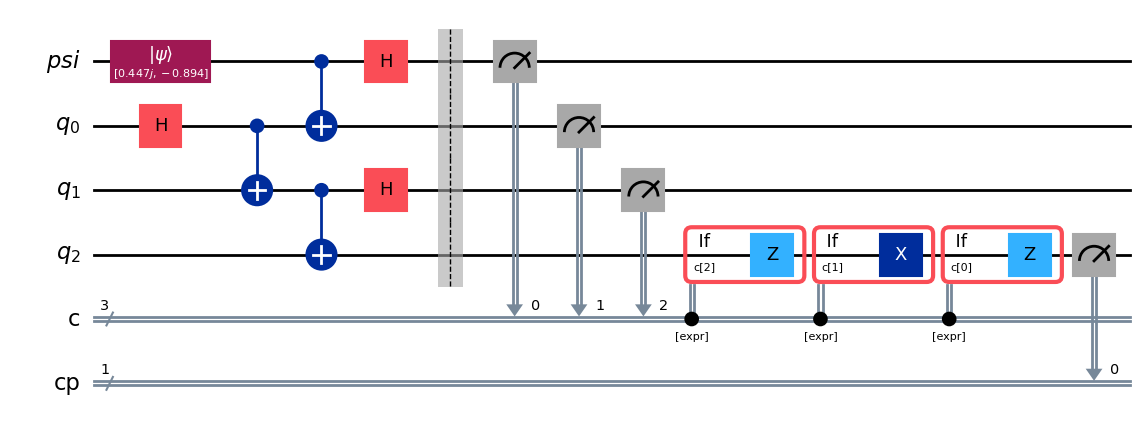

In [ ]:
input_psi = quantum_info.Statevector(np.sqrt(0.2)*np.array([1j, 0])) - quantum_info.Statevector(np.sqrt(0.8)*np.array([0, 1]))
# input_psi = quantum_info.Statevector(np.array([np.sqrt(0.2)*1j, np.sqrt(0.8)]))
input_psi.draw('latex')

def teleportation():
    psi_circuit = QuantumRegister(1, name='psi')
    q_circuit = QuantumRegister(3, name='q')
    cls = ClassicalRegister(3, name='c')
    cls_phi = ClassicalRegister(1, name='cp')

    circuit = QuantumCircuit(psi_circuit, q_circuit, cls, cls_phi)

    circuit.initialize(input_psi, 0)

    circuit.h(1)
    circuit.cx(1,2)

    circuit.cx([0, 2], [1, 3])
    # circuit.cx(2, 3)

    circuit.h([0, 2])
    circuit.barrier()
    circuit.measure([0, 1, 2], [0, 1, 2])

    with circuit.if_test(expr.lift(cls[2])):
        circuit.z(3)

    with circuit.if_test(expr.lift(cls[1])):
        circuit.x(3)

    with circuit.if_test(expr.lift(cls[0])):
        circuit.z(3)

    circuit.measure(3, 3)

    return circuit

telep_circuit = teleportation()
telep_circuit.draw('mpl')

Output state: sqrt(0.21)|0> + sqrt(0.79)|1>


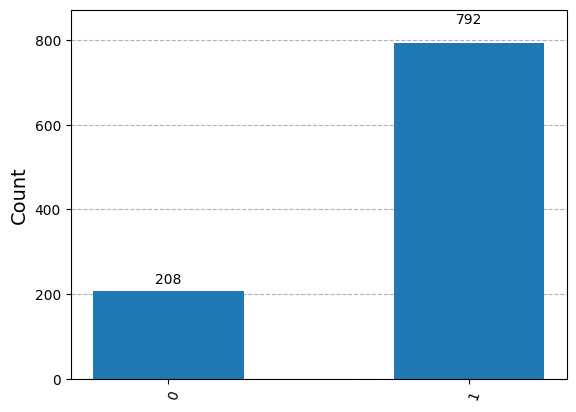

In [ ]:
aer_sim = AerSimulator()
telep_circuit = transpile(telep_circuit, backend=aer_sim)

sampler = Sampler(backend=aer_sim)

total_shots = 1000
result = sampler.run([telep_circuit], shots=total_shots).result()

stats = result[0].data.cp.get_counts()

prob_0 = stats['0']/total_shots
prob_1 = stats['1']/total_shots

print(f'Output state: sqrt({prob_0:.02f})|0> + sqrt({prob_1:.02f})|1>')

plot_histogram(stats)